In [70]:
import pandas as pd
from utils import io
from utils import ts_utils
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller, pacf

get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')



Consumables 0
Consumables 2
Consumables 4
Consumables 10
Consumables 13
Consumables 33
EQ 0
EQ 2
EQ 4
EQ 10
EQ 13
EQ 33
EQ 56
Service 0
Service 2
Service 4
Service 10
Service 13
Service 33
Service 56


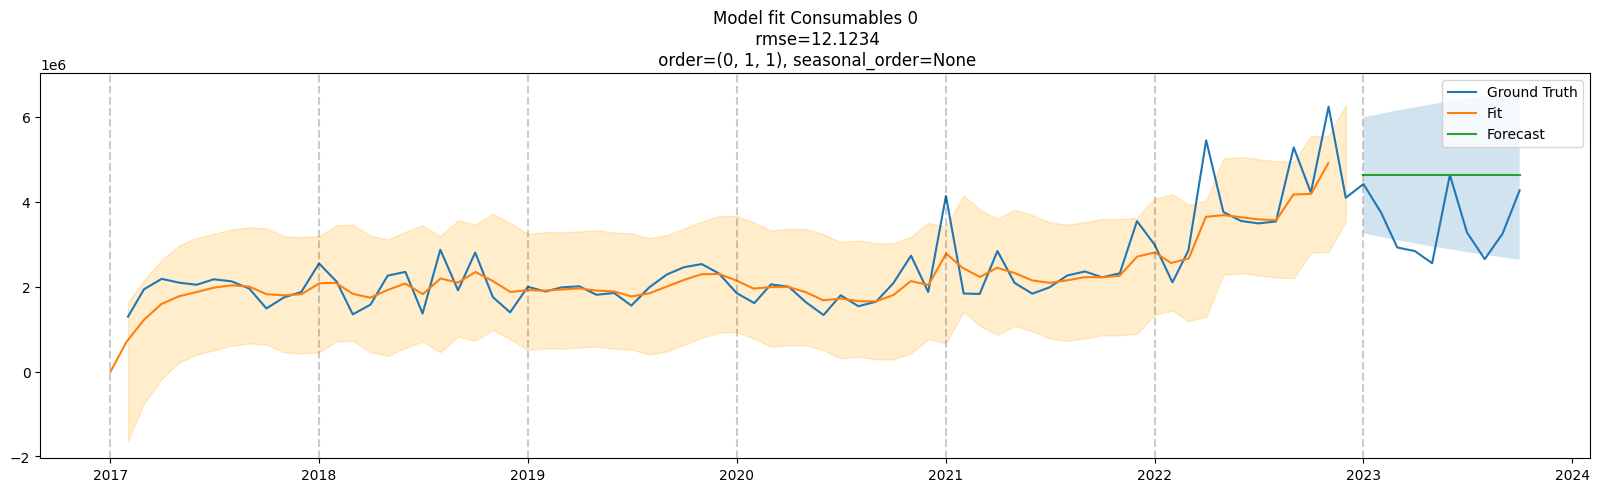

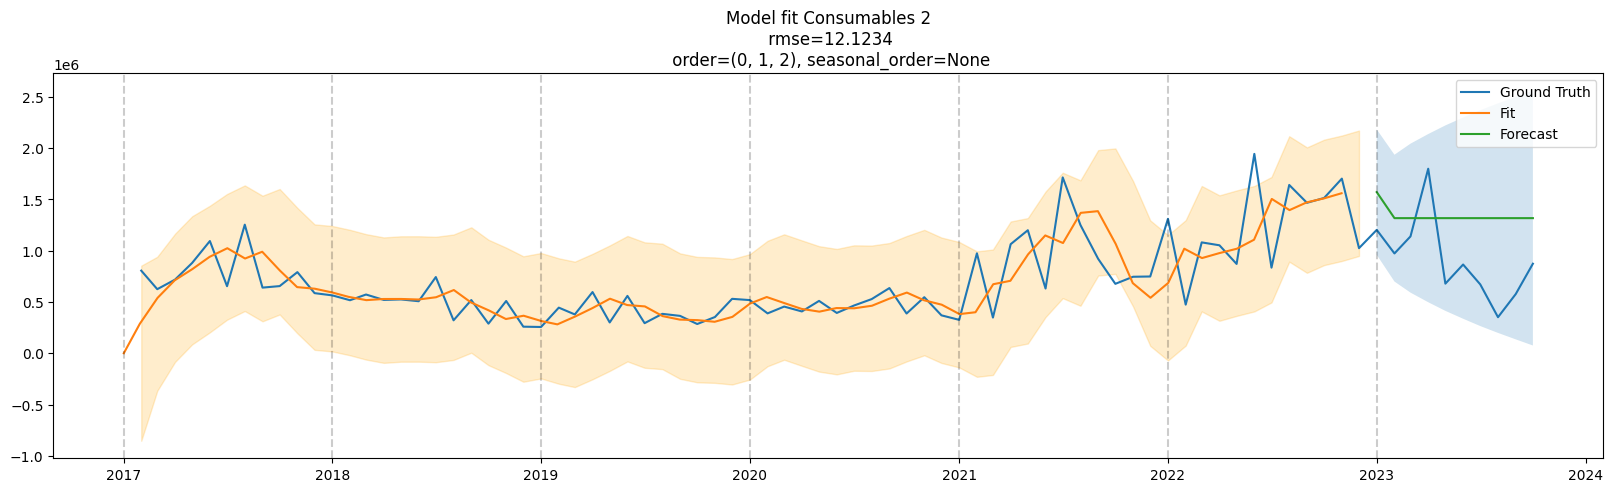

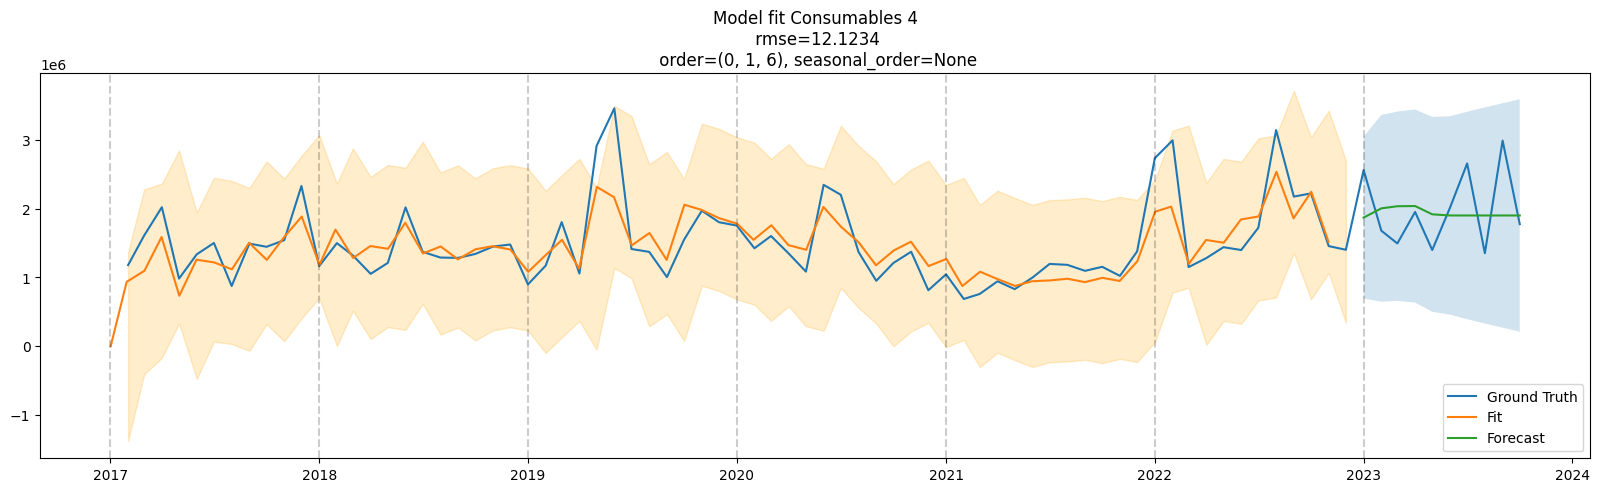

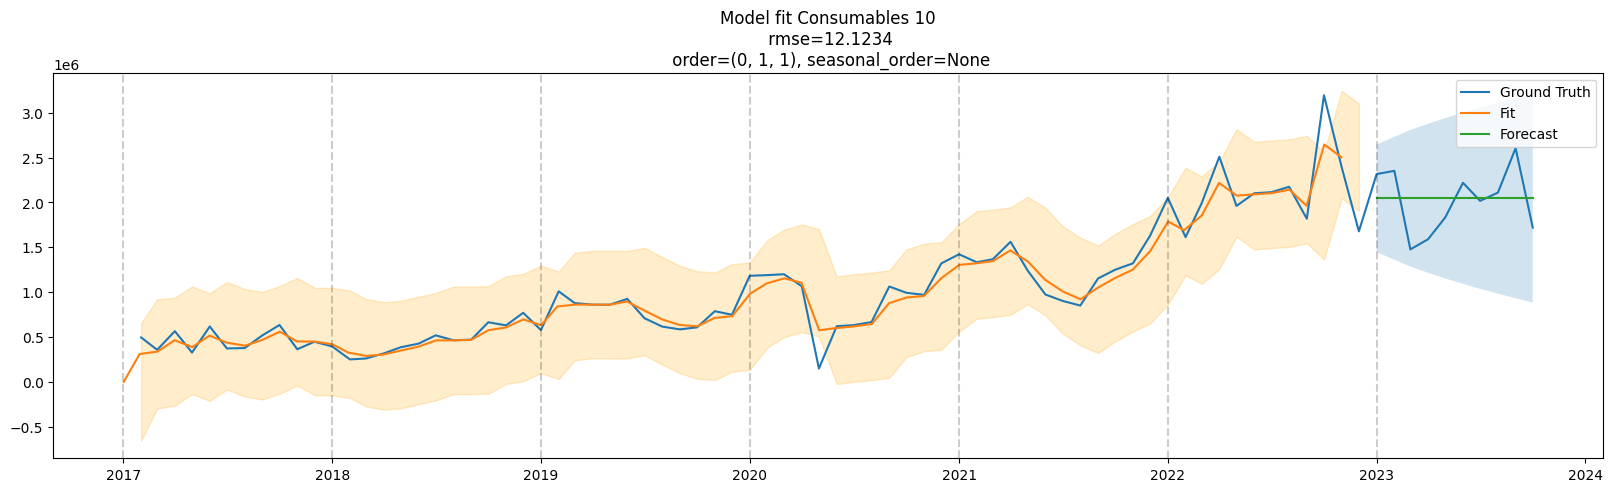

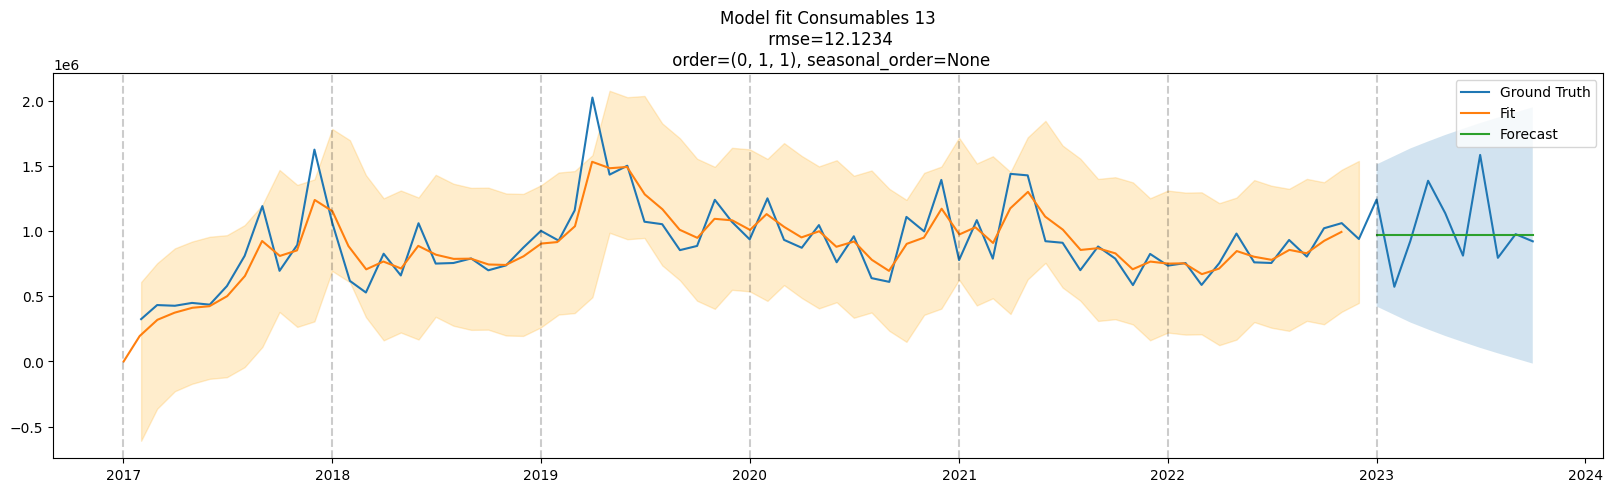

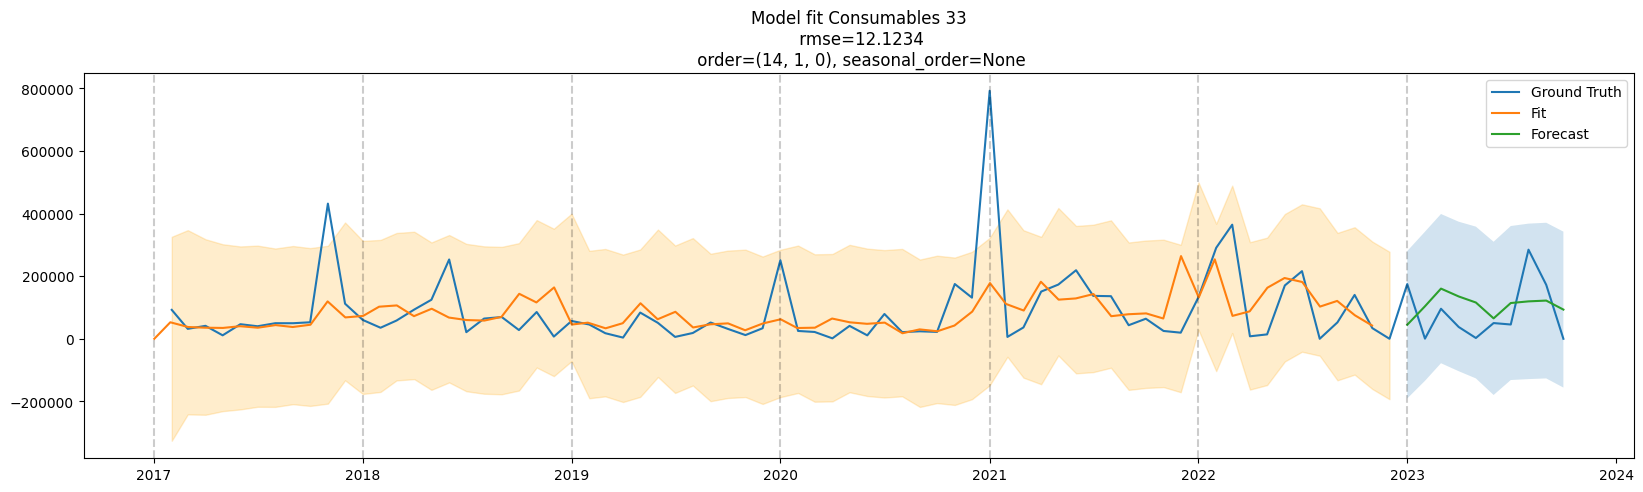

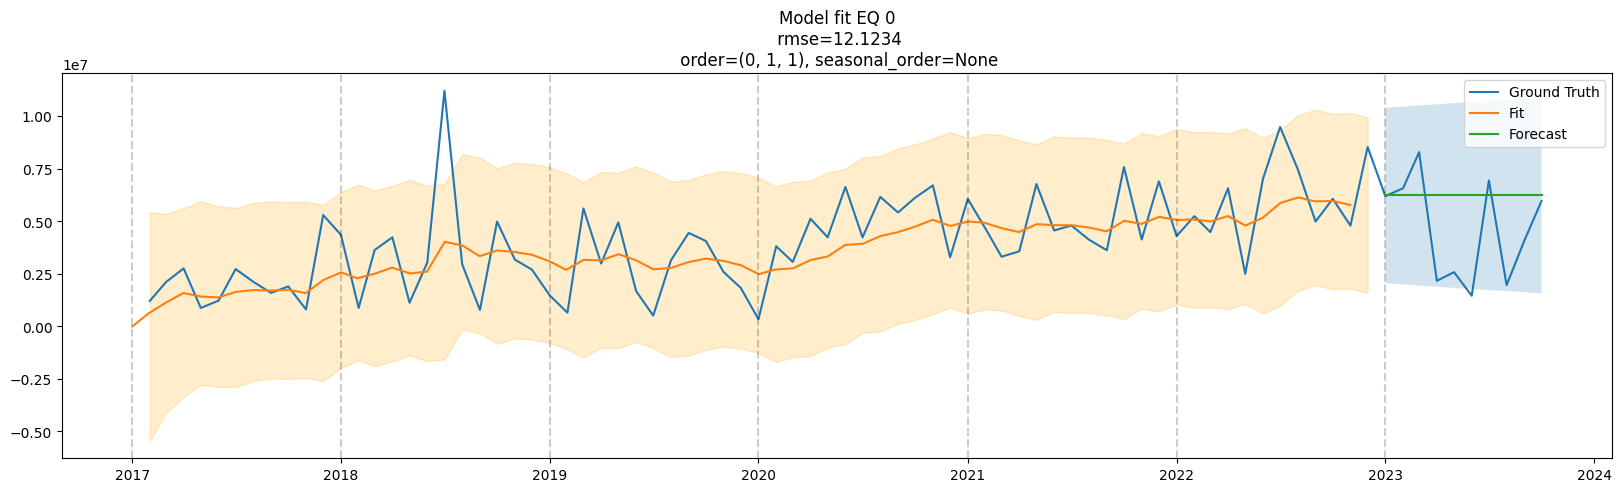

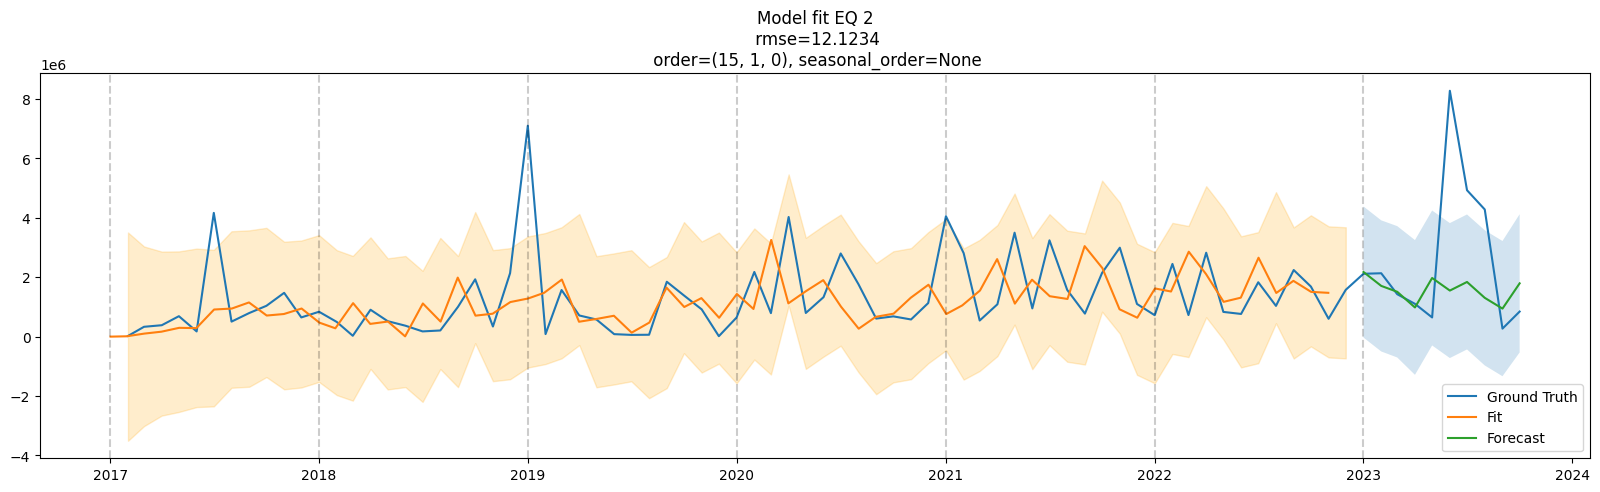

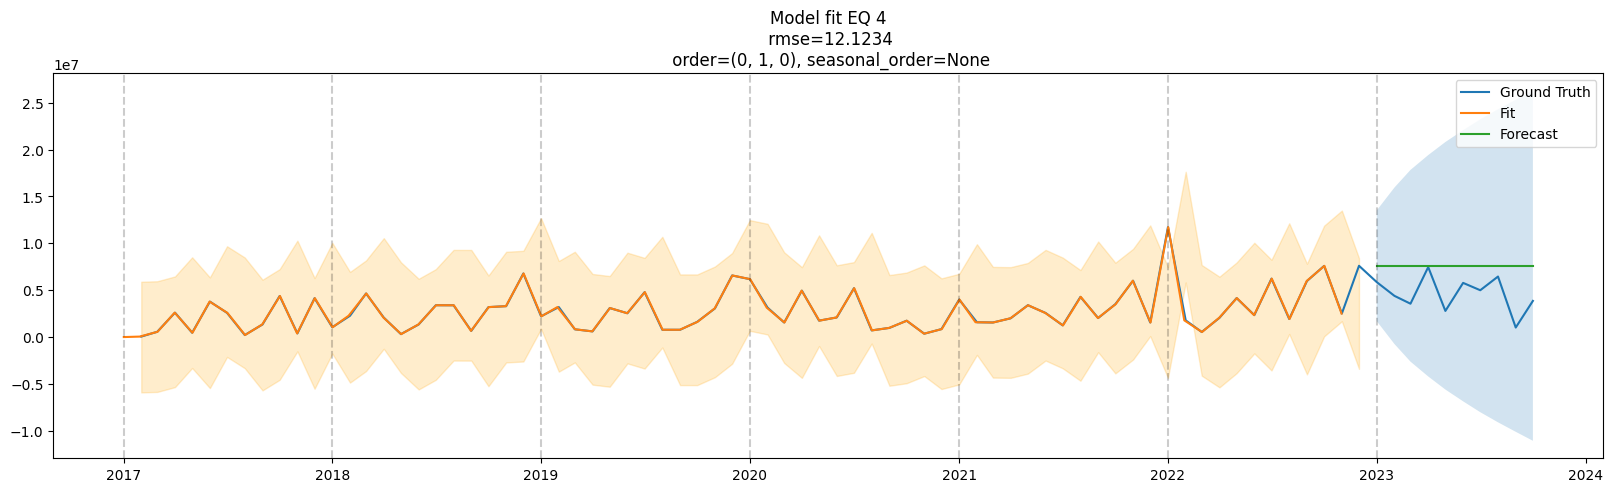

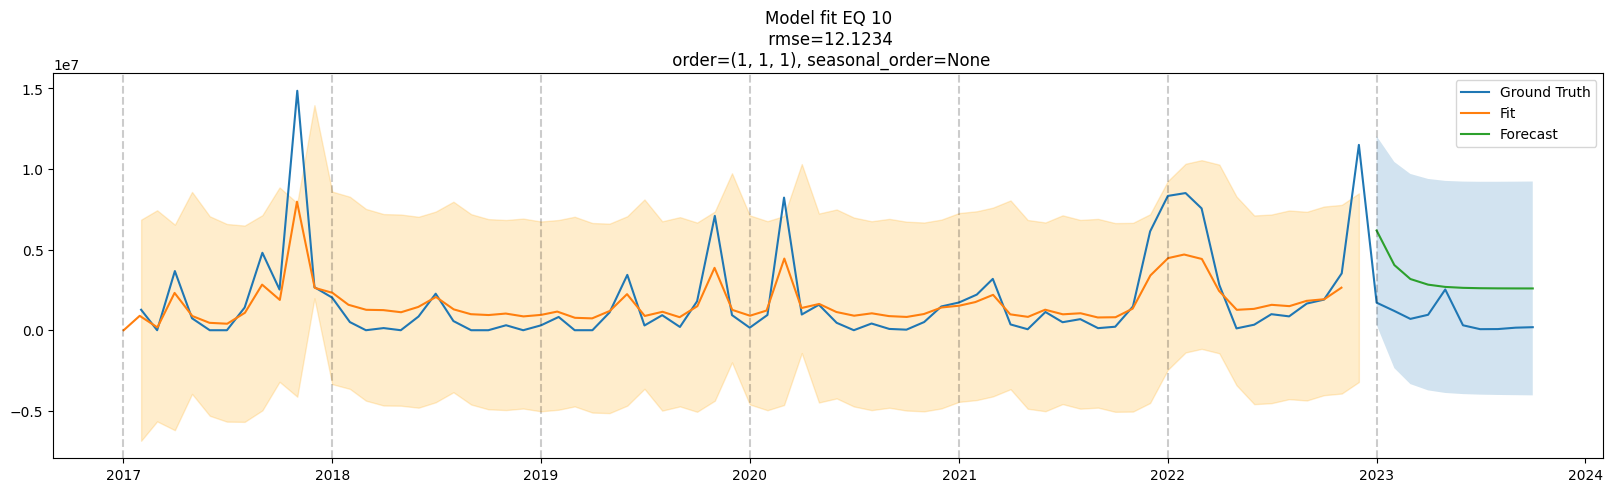

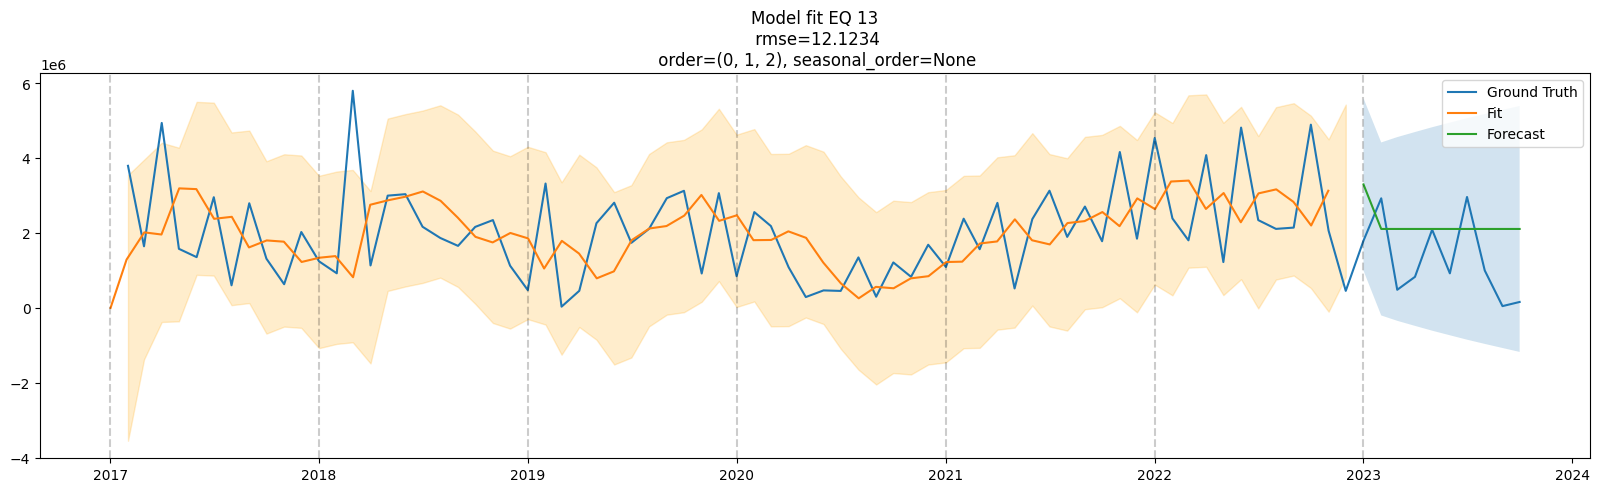

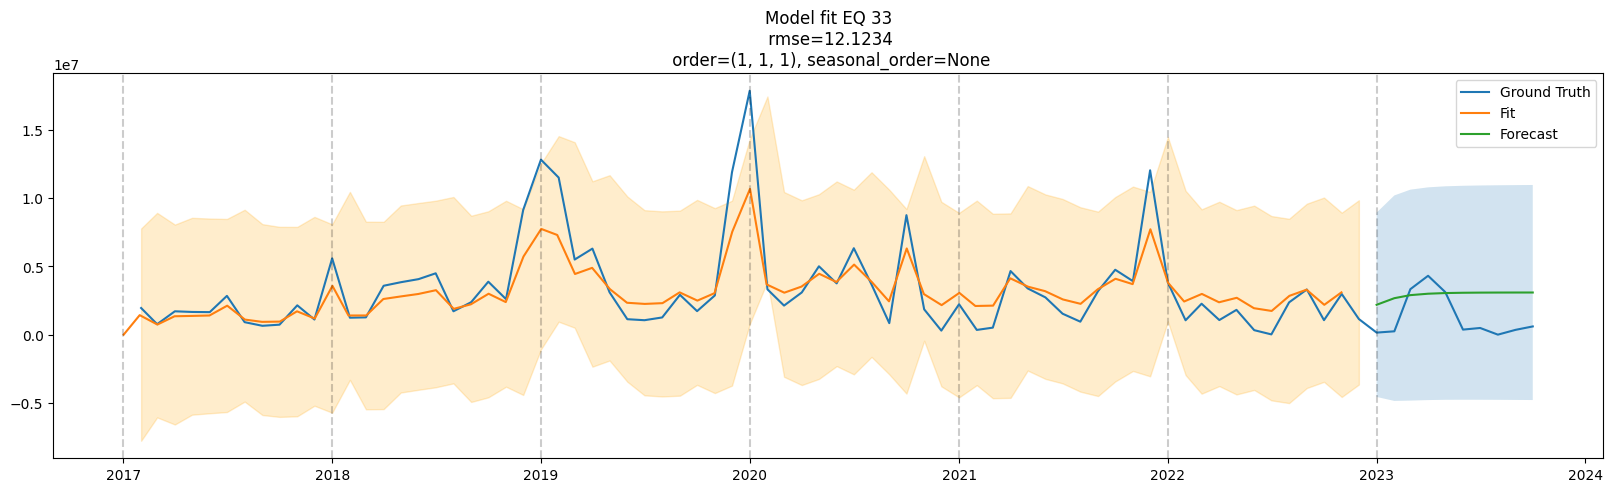

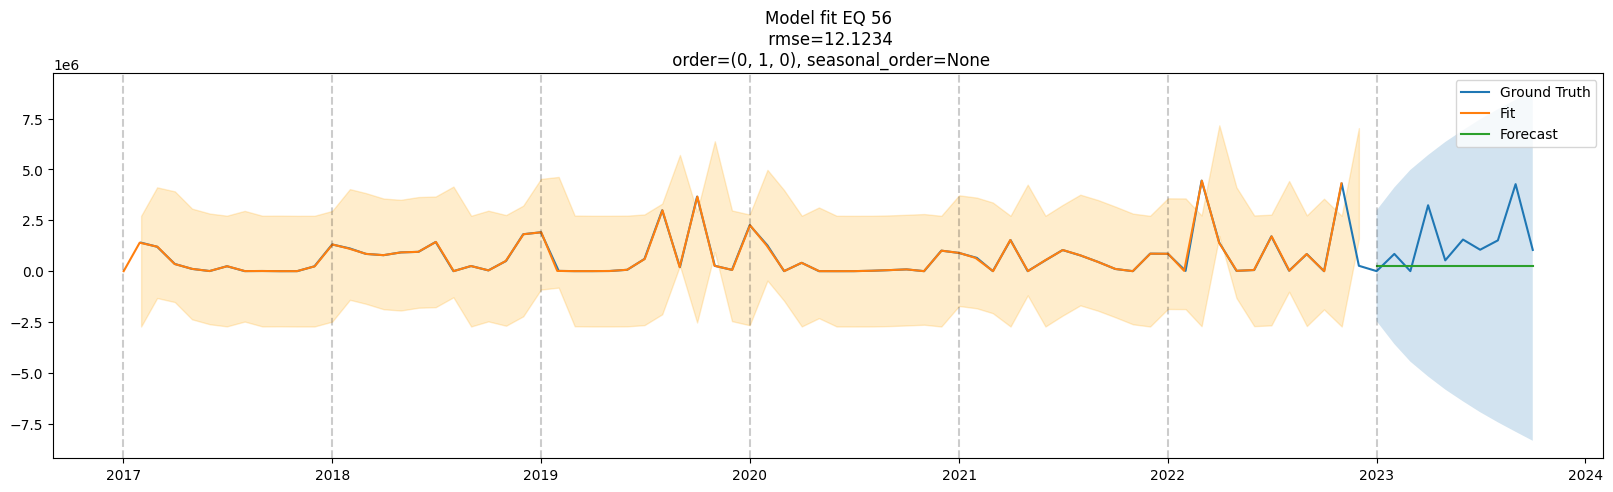

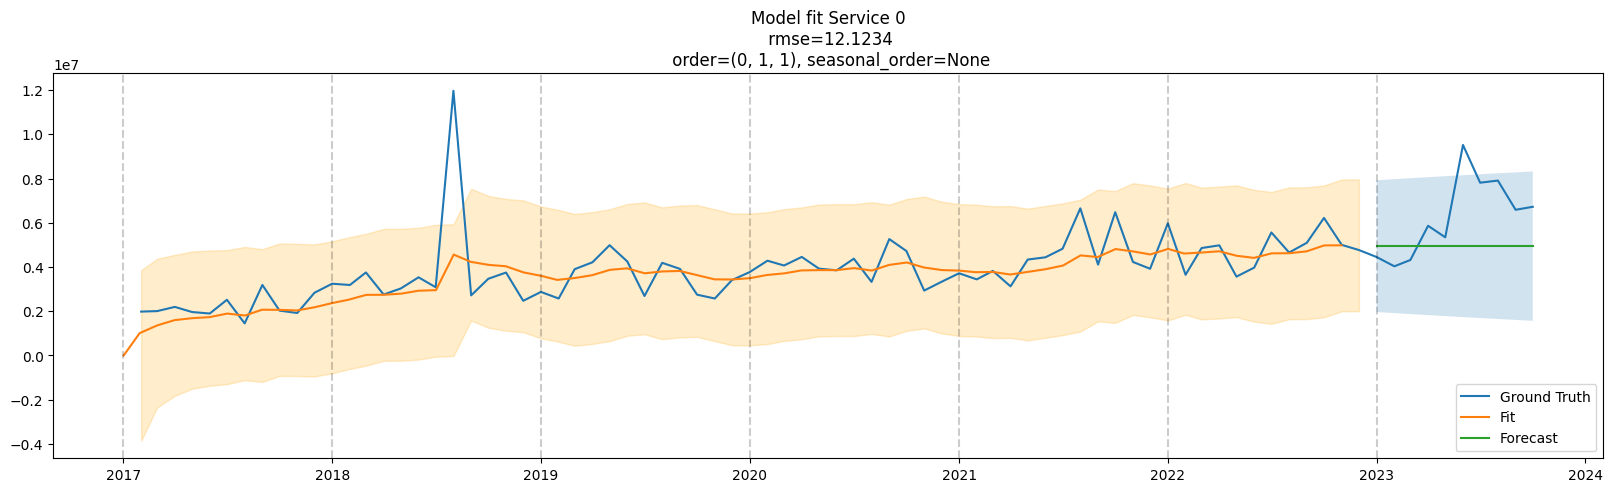

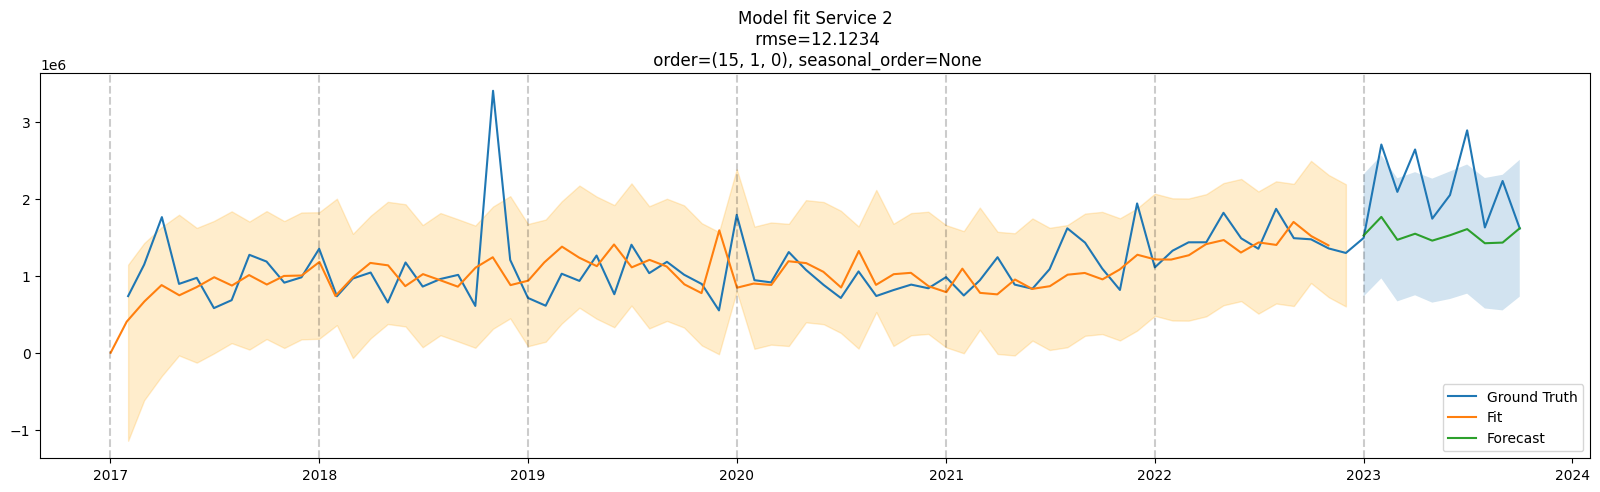

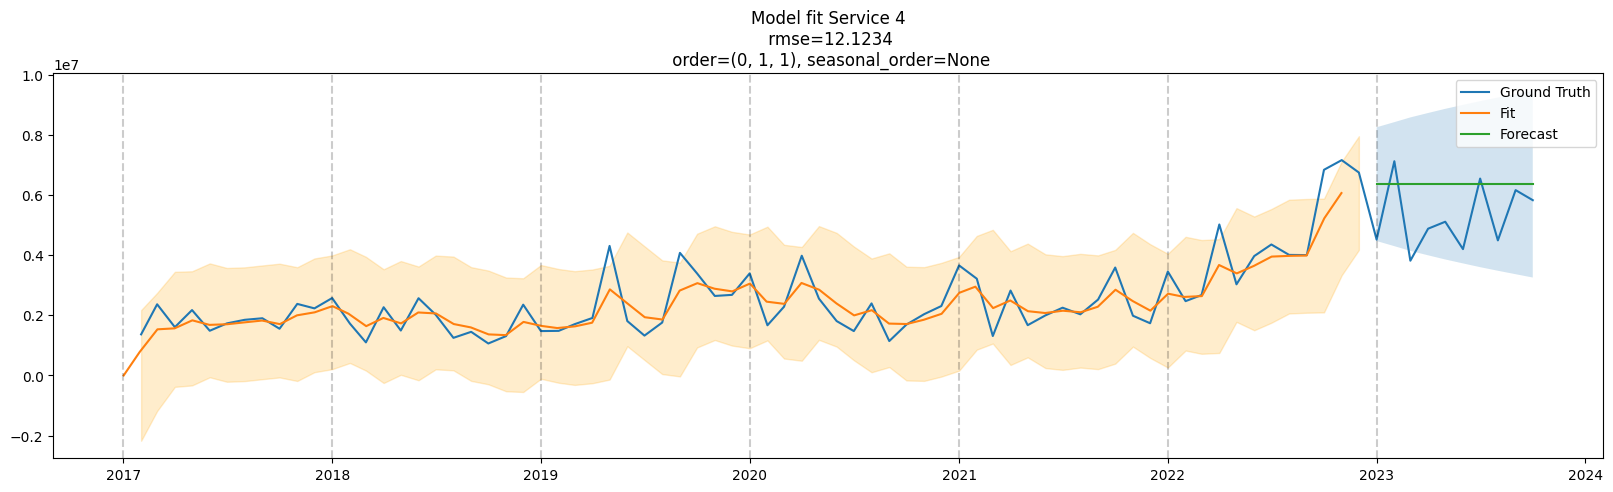

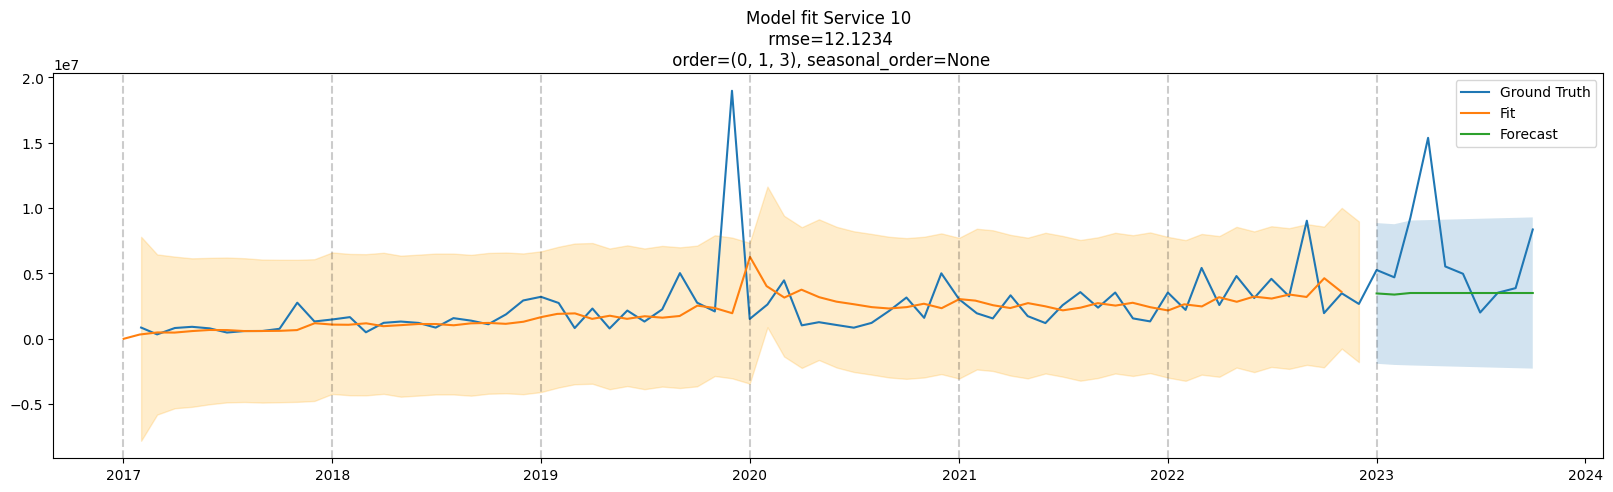

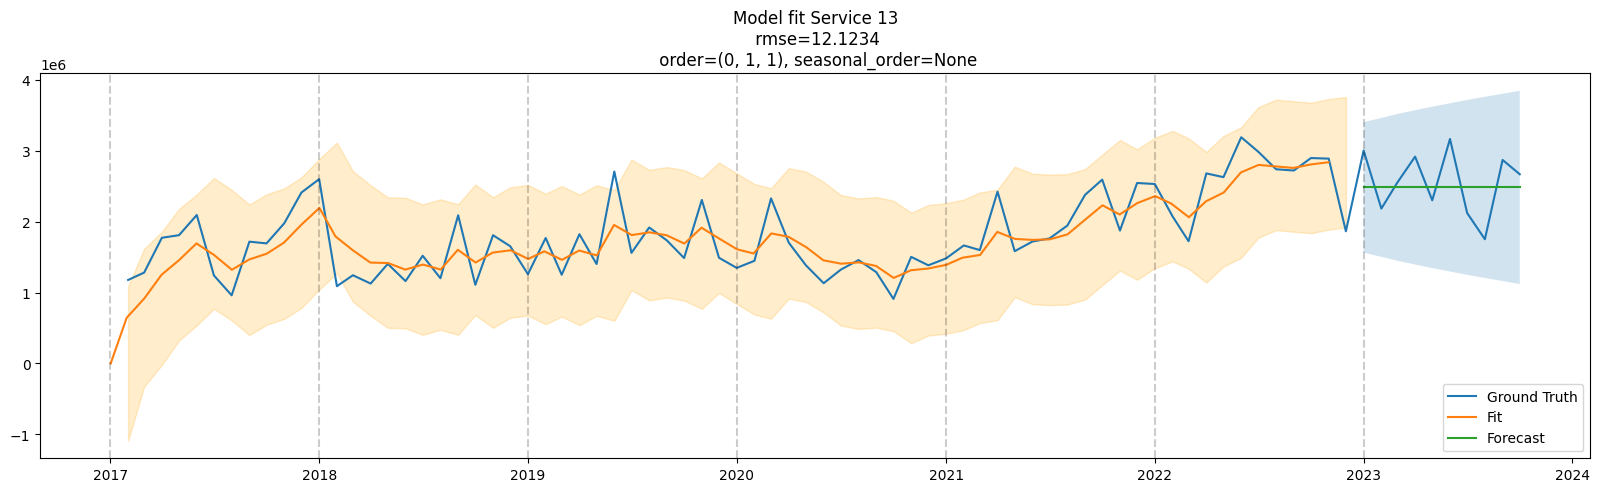

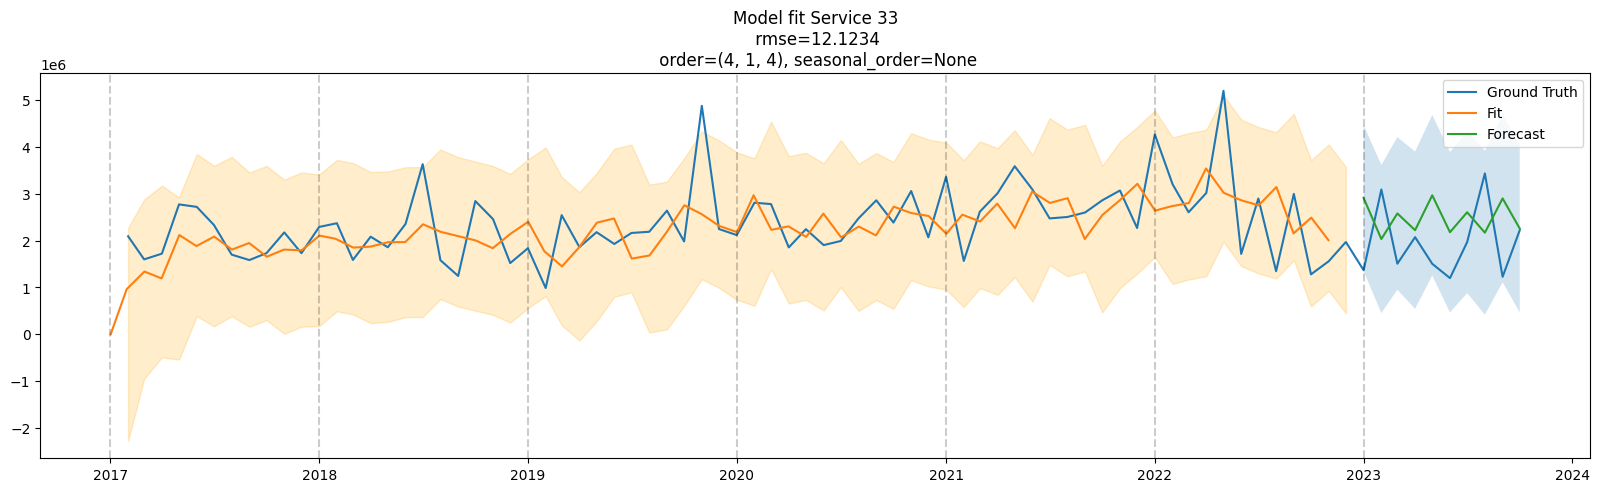

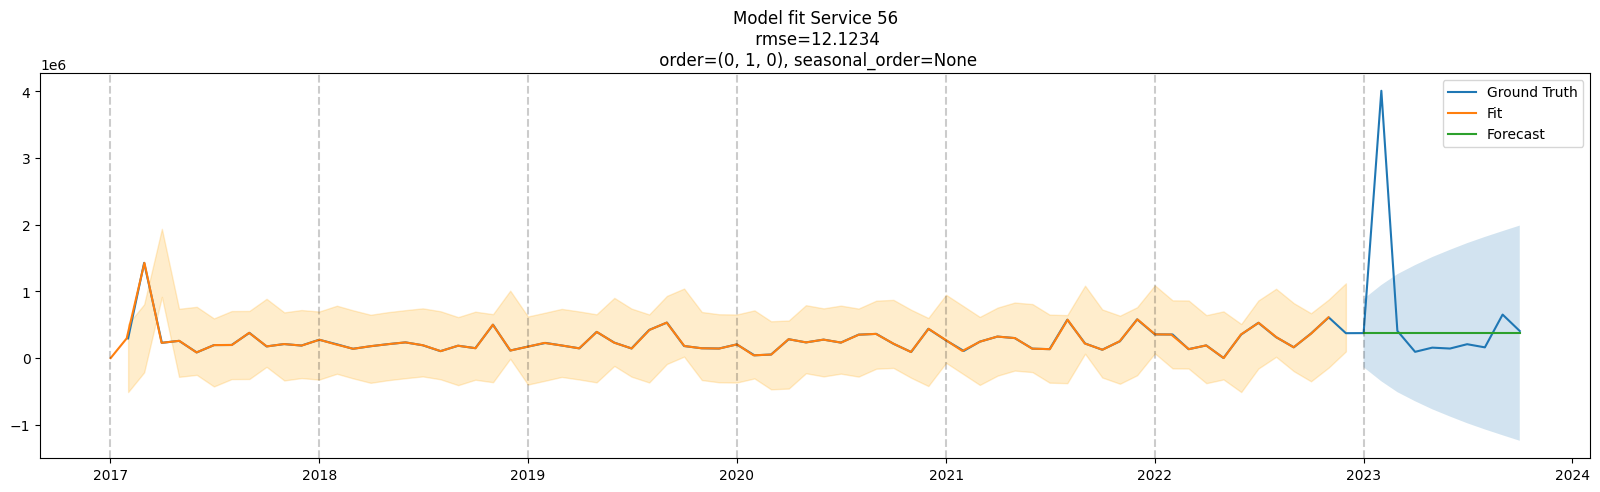

In [75]:
importlib.reload(io)
importlib.reload(ts_utils)
data_handler = io.DataHandler(data_path = 'data')

bs_areas = data_handler.get_bussines_areas()
# bs_areas = ['EQ']
# bs_areas = ['Consumables']

regions = data_handler.get_regions()
# regions = [33]
# regions = [56]

exog_features = [
    'MGDP_Index',
    'EBIT_Index',
    'Revenue_Index',
    'fleet1',
    'fleet2',
    'fleet3',
    'Copper',
    'Gold',
    'Iron Ore',
    'Nickel',
    'Silver',
    'Zinc',
]

all_models = True

for bs_area in bs_areas:
    for region in regions: 
        
        if bs_area == 'Consumables' and region == 56:
            continue
        
        name = f'{bs_area}_{region}'
        full_name = f'{bs_area} {region}'
        
        print(full_name)

        sales_bus_region = data_handler.get_sales_per_business_area_and_region(business_area = bs_area,
                                                                               region = region)
        
        sales_bus_region = data_handler.add_monthly_financial_info(sales_df = sales_bus_region,
                                                                   region = region)

        ts_handler = ts_utils.TimeSeriesHandler(name = full_name,
                                                df = sales_bus_region,
                                                endog = 'sales_value')
                                                # endog = 'sales_value', exog = exog_features)
        # if len(ts_handler.test) < 5:
        #     print('TEST NOT FULL ' + full_name)
        #     print(len(ts_handler.test))

        # exog_forecast = pd.DataFrame()
        # for exog in ts_handler.exog:
        #     # print(exog)
        #     exog_name = f'{name}_exog_{exog}'
        #     exog_ts_handler = ts_utils.TimeSeriesHandler(name = exog_name,
        #                                                  df = sales_bus_region,
        #                                                  endog = exog,
        #                                                  exog = None)
        #     # if len(exog_ts_handler.test) < 5:
        #     #     print('TEST NOT FULL '+ full_name + ' ' + exog_name)
        #     #     print(len(exog_ts_handler.test))
        #     exog_ts_handler.determine_orders()
        #     exog_ts_handler.fit_sarimax_exog(plot = False if all_models else True)
        #     exog_forecast[exog] = exog_ts_handler.forecast

        # ts_handler.set_exog_forecast(exog_forecast)

        ts_handler.determine_orders()

        ts_handler.fit_sarimax(name = name,
                               plot_fit = True,
                               plot_prediction = True,
                               rolling_prediction = True,
                               plot_rolling = True)
        
        
        if not all_models: break
    if not all_models: break
